In [145]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
%matplotlib inline

Data from: [http://www.seanlahman.com/baseball-archive/statistics/](http://www.seanlahman.com/baseball-archive/statistics/)

Data dictionary available here: [http://www.seanlahman.com/files/database/readme2017.txt](http://www.seanlahman.com/files/database/readme2017.txt)

In [167]:
players = pd.read_csv('data/People.csv')
batting = pd.read_csv('data/Batting.csv')

In [168]:
print("There are {0} players in the dataset.".format(players.shape[0]))
print("There are {0} batting records in the dataset.".format(batting.shape[0]))

There are 19370 players in the dataset.
There are 104324 batting records in the dataset.


Let's calculate average runs per season per player

In [169]:
avg_runs = pd.DataFrame(batting.groupby(['playerID']).R.mean())

We can check the average runs (per season) for Bryce Harper:

In [170]:
avg_runs.loc['harpebr03']

R    84.5
Name: harpebr03, dtype: float64

In [171]:
df = players.set_index('playerID').join(avg_runs, how='left')

Let's focus on just players who actually have scored runs:

In [172]:
df = df[df['R'] > 0]

In [173]:
print("There are {0} players who scored runs.".format(df.shape[0]))

There are 13596 players who scored runs.


Let's generate dummy variables for whether the player bats and throws righthanded, lefthanded, or both:

In [174]:
bats_dummies = pd.get_dummies(df.bats, prefix='bats')
throws_dummies = pd.get_dummies(df.throws, prefix='throws')

In [175]:
df = df.join(bats_dummies)
df = df.join(throws_dummies)

Let's take a look at the distribution of runs using a kernel density estimator:

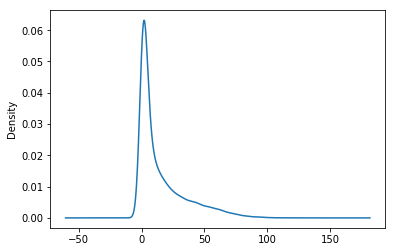

In [176]:
df['R'].plot(kind='kde')

Let's focus just on the features we think will be predictive of runs:

- birth month
- weight
- height
- batting hand
- throwing hand

In [177]:
df = df.reset_index()
df = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R', 'R']].dropna()
X = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R']]
y = df['R']

Now let's split our data into training and test sets:

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [181]:
results = sm.OLS(y_train, X_train).fit()

In [182]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     861.0
Date:                Mon, 06 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:36:06   Log-Likelihood:                -45493.
No. Observations:               10420   AIC:                         9.100e+04
Df Residuals:                   10412   BIC:                         9.106e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
birthMonth     0.0885      0.054      1.643      0.1